In [302]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score

Loading /Users/sarabadih/Desktop/mne-python/f096049-Hb_Moments.snirf


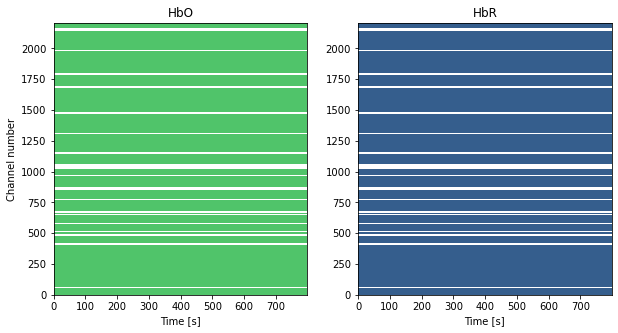

In [1]:
# Read in Training Dataset
import numpy as np
import matplotlib.pyplot as plt
from mne.io.snirf import read_raw_snirf

# %% Reading the file
#path_to_snirf = "2021_08-Finger_Tapping-Hb.snirf"
#path_to_snirf = "1745f1d-Moments.snirf"
path_to_snirf = "f096049-Hb_Moments.snirf" #Patient 1 Run 1 data
snirf = read_raw_snirf(path_to_snirf)

# %% Obtaining general information 
# you can query snirf.info for measurement data/time
# information about the channels (their names and locations) can also be accessed in snirf.info as follows:
channel_names = [x['ch_name'] for x in snirf.info['chs']]
is_hbo = np.array([1 if channel_name.endswith(
   'HbO') else 0 for channel_name in channel_names], dtype=bool)
channel_locations_3d = [x['loc'][:3] for x in snirf.info['chs']] 

# %% Obtaining NIRS data
a = snirf.get_data()

# %% Plotting 
_, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].pcolor(snirf.times, np.arange(np.sum(is_hbo)),
            a[is_hbo, :], shading='nearest')
ax[0].set_title('HbO')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Channel number')
ax[1].pcolor(snirf.times, np.arange(np.sum(~is_hbo)),
            a[~is_hbo, :], shading='nearest')
ax[1].set_title('HbR')
ax[1].set_xlabel('Time [s]')
plt.show() 

Text(0, 0.5, 'Left Channel')

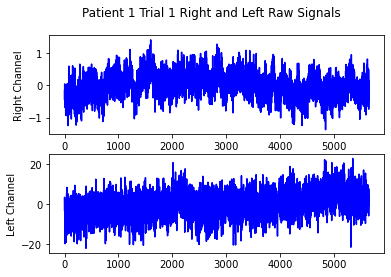

In [81]:
#Patient 1 Run 1, Obtaining 2 HbO Channels (Left and Right of Brain)

#Right Channel HbO Signal
assert(is_hbo[8])== True #Make sure we are choosing a HbO signal (Oxygenated Hemoglobin)
assert(snirf.get_data().shape)==(4412,5653) #4412 channels by 5653 signal points per channel
snirf_d=snirf.get_data()
d=snirf_d[8,:] #Extract the 8th channel signal
fig, axs = plt.subplots(2)
fig.suptitle('Patient 1 Trial 1 Right and Left Raw Signals')
axs[0].plot(d,color="blue",label="Right")
axs[0].set_ylabel("Right Channel")

#Left Channel HbO Signal
assert(is_hbo[4080])== True #Make sure we are choosing a HbO signal (Oxygenated Hemoglobin)
f=snirf_d[4080,:] #Extract the 4080th channel signal
axs[1].plot(f,color="blue",label="Left")
axs[1].set_ylabel("Left Channel")

Text(0, 0.5, 'Left Channel')

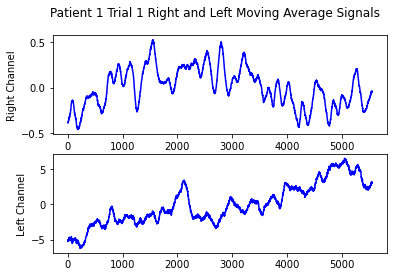

In [82]:
#Apply Moving Average to the data
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    return np.convolve(np.squeeze(values), weights, 'valid')

fig, axs = plt.subplots(2)
fig.suptitle('Patient 1 Trial 1 Right and Left Moving Average Signals')
axs[0].plot(movingaverage(d, 100),color="blue",label="Right")
axs[0].set_ylabel("Right Channel")

#Left Channel HbO Signal
assert(is_hbo[4080])== True #Make sure we are choosing a HbO signal (Oxygenated Hemoglobin)
f=snirf_d[4080,:] #Extract the 8th channel signal
axs[1].plot(movingaverage(f, 100),color="blue",label="Left")
axs[1].set_ylabel("Left Channel")

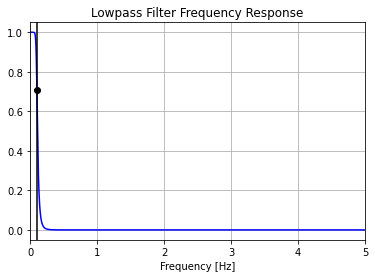

In [83]:
#Low Pass Filter
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Setting standard filter requirements.
order = 6
fs = 10   #This is the sampling rate I derived from the cutoff frequency they used(0.1=Fs/2)(Sampling Frequency has to be greater than 0.2)   
cutoff = 0.1  

b, a = butter_lowpass(cutoff, fs, order)

# Plotting the frequency response.
w, h = freqz(b, a, worN=8000)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()


[-3.27457697e-10 -4.17814525e-09 -2.67392429e-08 ... -1.43750880e-01
 -1.41884523e-01 -1.40030690e-01]


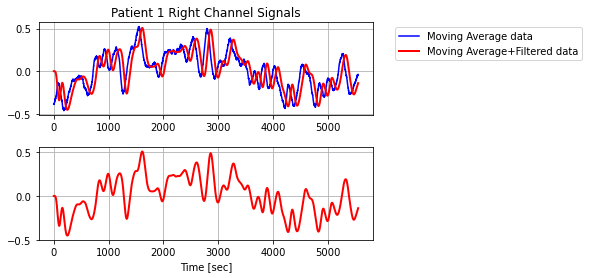

In [84]:
# Filter Setup
T = 800         # value taken in seconds
t = np.linspace(0, T, 5653, endpoint=False)

# Filtering and plotting
p1_rf = butter_lowpass_filter(movingaverage(d,100), cutoff, fs, order) #patient 1 right filtered signal
print(p1_rf)
plt.subplot(2, 1, 1)
plt.title("Patient 1 Right Channel Signals")
plt.plot(movingaverage(d,100), 'b-', label='Moving Average data')
plt.plot(p1_rf, 'r-', linewidth=2, label='Moving Average+Filtered data')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1))
plt.subplot(2, 1, 2)
plt.plot(p1_rf, 'r-', linewidth=2, label='Moving Average+Filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.subplots_adjust(hspace=0.35)

Text(0.5, 0, 'Time [sec]')

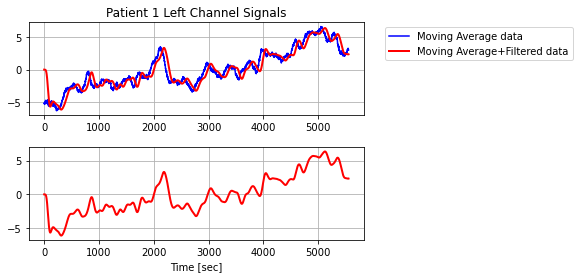

In [111]:
# Filtering and plotting
p1_lf = butter_lowpass_filter(movingaverage(f,100), cutoff, fs, order) #patient 1 left filtered signal
plt.subplot(2, 1, 1)
plt.plot(movingaverage(f,100), 'b-', label='Moving Average data')
plt.plot(p1_lf, 'r-', linewidth=2,label='Moving Average+Filtered data')
plt.title("Patient 1 Left Channel Signals")
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1))
plt.subplot(2, 1, 2)
plt.plot(p1_lf, 'r-', linewidth=2, label='Moving Average+Filtered data')
plt.grid()
plt.subplots_adjust(hspace=0.35)
plt.xlabel('Time [sec]')

In [219]:
print(p1_lf.shape)
print(movingaverage(f,100).shape)
print(f.shape)
print(snirf.times.shape)
print(movingaverage(snirf.times,100).shape)

(5554,)
(5554,)
(5653,)
(5653,)
(5554,)


Loading /Users/sarabadih/Desktop/mne-python/157dcb4-Hb_Moments.snirf


Text(0, 0.5, 'Left Channel')

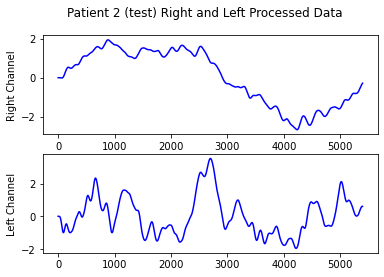

In [288]:
#Read in Test DataSet
path = "157dcb4-Hb_Moments.snirf" #Patient 1 Run 1 data
snirf_test = read_raw_snirf(path)

channel_names_test = [z['ch_name'] for z in snirf.info['chs']]
is_hbo_test = np.array([1 if channel_name.endswith(
   'HbO') else 0 for channel_name in channel_names_test], dtype=bool)
channel_locations_3d_test = [z['loc'][:3] for z in snirf_test.info['chs']] 

#Right Channel HbO Signal
assert(is_hbo_test[8])== True #Make sure we are choosing a HbO signal (Oxygenated Hemoglobin)
snirf_t=snirf_test.get_data()
test_r=snirf_t[8,:] #Extract the 8th channel signal

#Left Channel HbO Signal
assert(is_hbo_test[152])== True #Make sure we are choosing a HbO signal (Oxygenated Hemoglobin)
test_l=snirf_t[152,:] #Extract the 152th channel signal 
            #Figure out why 4080th channel wasn't coming up

#Apply Moving Average and Filter
p_test_r=butter_lowpass_filter(movingaverage(test_r,100), cutoff, fs, order)
p_test_l=butter_lowpass_filter(movingaverage(test_l,100), cutoff, fs, order)

#Plot
fig, axs = plt.subplots(2)
fig.suptitle('Patient 2 (test) Right and Left Processed Data')
axs[0].plot(p_test_r,color="blue",label="Right")
axs[0].set_ylabel("Right Channel")

#Left Channel HbO Signal
axs[1].plot(p_test_l,color="blue",label="Left")
axs[1].set_ylabel("Left Channel")

In [295]:
print(snirf_test.times.shape)
print(snirf.times.shape) #Our timestamps are different for training and testing data

(5493,)
(5653,)


In [256]:
#Logistic Regression Setup

#What would be our y labels in this case
df = pd.read_excel (r'/Users/sarabadih/Desktop/f096049_task_events.xlsx', sheet_name='f096049_task_events')
display(df)

#Extract the timestamp and block_type columns
time_stamps=df["timestamp"] #582 timestamps
block_type=df["block_type"]

,timestamp,event,duration,experiment_type,block,block_type,trial,trial_type
0,0.000000,start_experiment,789.392488,finger_tapping,NaN,NaN,NaN,NaN
1,0.089842,start_rest,20.018517,finger_tapping,NaN,NaN,NaN,NaN
2,20.108440,start_block,17.714409,finger_tapping,1.0,right,NaN,NaN
3,20.156964,start_ITI,0.513069,finger_tapping,1.0,right,NaN,NaN
4,20.670118,start_trial,0.806002,finger_tapping,1.0,right,1.0,middle
...,...,...,...,...,...,...,...,...
577,766.298867,start_trial,0.791355,finger_tapping,20.0,right,259.0,index
578,767.139773,start_ITI,0.752528,finger_tapping,20.0,right,NaN,NaN
579,767.892369,start_trial,0.802379,finger_tapping,20.0,right,260.0,index
580,768.739782,start_ITI,0.567454,finger_tapping,20.0,right,NaN,NaN


In [242]:
#Boolean Array for Training Datatset
avg=movingaverage(snirf.times,100)
blocks=np.empty(avg.size) #5554 #This is a boolean array representing the y_train

for i in range(len(avg)): #0 to 5554   
    #Right Ranges
    if avg[i,] >=20.1084403991699 and avg[i,] <= 37.2906377315521:
        blocks[i]=0
    elif avg[i,] >=96.0085089206695 and avg[i,] <= 115.45904135704:
        blocks[i]=0
    elif avg[i,] >=215.648464679718 and avg[i,] <=233.39488863945:
        blocks[i]=0
    elif avg[i,] >=254.080522060394 and avg[i,] <=270.762350082397:
        blocks[i]=0
    elif avg[i,] >=329.180588245391 and avg[i,] <=347.297376155853:
        blocks[i]=0
    elif avg[i,] >=407.016450643539 and avg[i,] <=423.932327508926:
        blocks[i]=0
    elif avg[i,] >=521.084533214569 and avg[i,] <=538.435498714447:
        blocks[i]=0
    elif avg[i,] >=597.4884724617 and avg[i,] <=615.069853544235:
        blocks[i]=0
    elif avg[i,] >=673.024507522583 and avg[i,] <=691.171491146087:
        blocks[i]=0
    elif avg[i,] >=750.456876039505 and avg[i,] <=768.739782094955:
        blocks[i]=0

    #Left Ranges
    elif avg[i,] >=57.9085166454315 and avg[i,] <= 75.3247609138488:
        blocks[i]=1
    elif avg[i,] >=136.044531583786 and avg[i,] <= 155.393176078796:
        blocks[i]=1
    elif avg[i,] >=176.312454462051 and avg[i,] <= 194.860765457153:
        blocks[i]=1
    elif avg[i,] >=291.416473150253 and avg[i,] <=308.596531152725:
        blocks[i]=1
    elif avg[i,] >=368.048515081405 and avg[i,] <=386.398197889328:
        blocks[i]=1
    elif avg[i,] >=444.316514968872 and avg[i,] <=462.033178329467:
        blocks[i]=1
    elif avg[i,] >=482.384647130966 and avg[i,] <=500.434092283248:
        blocks[i]=1
    elif avg[i,] >=558.784443378448 and avg[i,] <=576.868988275528:
        blocks[i]=1
    elif avg[i,] >=635.356453895568 and avg[i,] <=651.970604419708:
        blocks[i]=1
    elif avg[i,] >=711.756521224975 and avg[i,] <=729.5390236377:
        blocks[i]=1
    else: 
        blocks[i]=0 #What do i set my nan to
#Assertions 
assert(blocks[4988]==1.0)
assert(blocks[93]==0.0)
assert(blocks[0]==0.0)
assert(blocks.shape==(5554,))

In [297]:
#Boolean Array for Test Dataset
avg=movingaverage(snirf_test.times,100)
y_test=np.empty(avg.size) #5394 #This is a boolean array representing the y_test

for i in range(len(avg)): #0 to 5394 
    #Right Ranges
    if avg[i,] >=20.0404598712921 and avg[i,] <=36.7387335300445 :
        y_test[i]=0
    elif avg[i,] >=95.0564653873443 and avg[i,] <=110.852770090103:
        y_test[i]=0
    elif avg[i,] >=168.936528921127 and avg[i,] <=185.850895881652:
        y_test[i]=0
    elif avg[i,] >=280.968475580215 and avg[i,] <=297.413870334625:
        y_test[i]=0
    elif avg[i,] >=355.496618986129 and avg[i,] <=373.029193162918:
        y_test[i]=0
    elif avg[i,] >=393.532568216323 and avg[i,] <=410.99533867836:
        y_test[i]=0
    elif avg[i,] >=505.112452745437 and avg[i,] <=521.557640314102:
        y_test[i]=0
    elif avg[i,] >=578.59243941307 and avg[i,] <=595.454669713974:
        y_test[i]=0
    elif avg[i,] >=653.588501691818 and avg[i,] <=670.286049604415:
        y_test[i]=0
    elif avg[i,] >=690.87249302864 and avg[i,] <=707.718648910522:
        y_test[i]=0

    #Left Ranges
    elif avg[i,] >=57.5405182838439 and avg[i,] <=74.6882479190826:
        y_test[i]=1
    elif avg[i,] >=131.9044659137726 and avg[i,] <=148.735503435134:
        y_test[i]=1
    elif avg[i,] >=206.252545595169 and avg[i,] <=223.566793203353:
        y_test[i]=1
    elif avg[i,] >=244.204538106918 and avg[i,] <=260.23189663887:
        y_test[i]=1
    elif avg[i,] >=317.669047117233 and avg[i,] <=334.762775421142:
        y_test[i]=1
    elif avg[i,] >=431.196606874465 and avg[i,] <=447.677822351455:
        y_test[i]=1
    elif avg[i,] >=468.0444419384 and avg[i,] <=484.558886051178:
        y_test[i]=1
    elif avg[i,] >=541.976702928543 and avg[i,] <=558.139090299606:
        y_test[i]=1
    elif avg[i,] >=616.340427160263 and avg[i,] <=632.904483795166:
        y_test[i]=1
    elif avg[i,] >=727.96843957901 and avg[i,] <=745.050502777099:
        y_test[i]=1
    else: 
        y_test[i]=0 #What do i set my nan to
#Assertions 
# assert(blocks[4988]==1.0)
# assert(blocks[93]==0.0)
# assert(blocks[0]==0.0)
# assert(blocks.shape==(5554,))

In [309]:
#Logistic Regression Model 1 (left channel data)

#Set Inputs
x1=p1_lf.reshape(-1,1) #left channel
x2=p1_rf.reshape(-1,1) #right channel

#Make the Model
model_r = LogisticRegression(solver='liblinear', random_state=0)

#Fit the Model
model_r.fit(x1,blocks) #Blocks is y_train

#Model Attributes
print("Our Labels Are:",model_r.classes_)
print("Our Models Intercept is:", model_r.intercept_)
print("Our Models Coefficients are:",model_r.coef_)

#Evaluate Model's Performance on Test Dataset
display(pd.DataFrame(model_r.predict_proba(p_test_l.reshape(-1,1)),columns=['Right Tap(0) ','Left Tap(1)']))
display(pd.DataFrame(model_r.predict(p_test_l.reshape(-1,1)),columns=['Model Prediction']))
y_pred=model_r.predict(p_test_l.reshape(-1,1)) #Predict tapping for test dataset
print("Accuracy:",accuracy_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred,average='weighted'))
print("Recall:",recall_score(y_test, y_pred,average='weighted'))

Our Labels Are: [0. 1.]
Our Models Intercept is: [-1.21679333]
Our Models Coefficients are: [[-0.00556762]]


,Right Tap(0),Left Tap(1)
0,0.771499,0.228501
1,0.771499,0.228501
2,0.771499,0.228501
3,0.771499,0.228501
4,0.771499,0.228501
...,...,...
5389,0.772099,0.227901
5390,0.772099,0.227901
5391,0.772098,0.227902
5392,0.772097,0.227903


,Model Prediction
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
5389,0.0
5390,0.0
5391,0.0
5392,0.0


Accuracy: 0.7806822395253986
Precision: 0.6094647591103918
Recall: 0.7806822395253986


/Users/sarabadih/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [313]:
print(y_test.shape)
print(y_pred.shape)
print(y_pred)
for i in range(len(y_pred)):
    if y_pred[i]==1:
        print("Found A 1 Prediction")

(5394,)
(5394,)
[0. 0. 0. ... 0. 0. 0.]


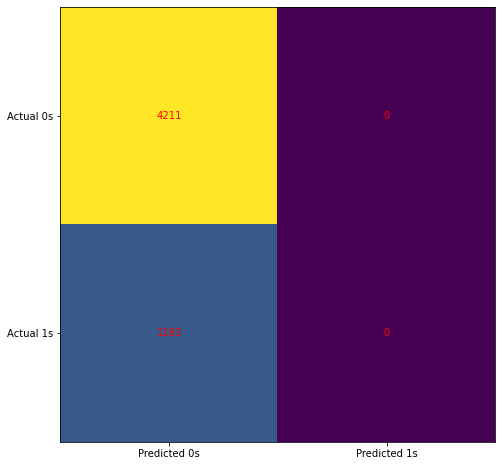

In [311]:
#More Evaluation Metrics
cm = confusion_matrix(y_test,y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [310]:
# Logistic Regression Model 2 (right channel data)

#Make the Model
model_l = LogisticRegression(solver='liblinear', random_state=0)

#Fit the Model
model_l.fit(x2,blocks)

#Model Attributes
print("Our Labels Are:", model_l.classes_)
print("Our Models Intercept is:", model_l.intercept_)
print("Our Models Coefficients are:",model_l.coef_)

#Evaluate Model's Performance on Test Dataset
display(pd.DataFrame(model_r.predict_proba(p_test_l.reshape(-1,1)),columns=['Right Tap(0) ','Left Tap(1)']))
display(pd.DataFrame(model_r.predict(p_test_l.reshape(-1,1)),columns=['Model Prediction']))
y_pred=model_r.predict(p_test_l.reshape(-1,1))
print("Accuracy:",accuracy_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred,average='weighted'))
print("Recall:",recall_score(y_test, y_pred,average='weighted'))

Our Labels Are: [0. 1.]
Our Models Intercept is: [-1.22984279]
Our Models Coefficients are: [[0.87373667]]


,Right Tap(0),Left Tap(1)
0,0.771499,0.228501
1,0.771499,0.228501
2,0.771499,0.228501
3,0.771499,0.228501
4,0.771499,0.228501
...,...,...
5389,0.772099,0.227901
5390,0.772099,0.227901
5391,0.772098,0.227902
5392,0.772097,0.227903


,Model Prediction
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
5389,0.0
5390,0.0
5391,0.0
5392,0.0


Accuracy: 0.7806822395253986
Precision: 0.6094647591103918
Recall: 0.7806822395253986


/Users/sarabadih/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Do we want to use cross validation to try and assess if changing certain hyperparameters like the l1,l2 penalty will improve our logistic regression model's accuracy?
https://realpython.com/logistic-regression-python/